In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from typing import List, Optional, Any
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class DeepARForecasting:
    def __init__(self, start_date: str, freq: str = 'ME', prediction_length: int = 5, epochs: int = 50, num_batches_per_epoch: int = 100):
        self.start_date = pd.Timestamp(start_date)
        self.freq = freq
        self.prediction_length = prediction_length
        self.epochs = epochs
        self.num_batches_per_epoch = num_batches_per_epoch
        self.time_series = []
        self.titles = []
        self.train_ds = None
        self.predictor = None
        
        # Set seeds for reproducibility
        np.random.seed(42)
        mx.random.seed(42)

    def add_time_series(self, series: np.ndarray, title: str):
        self.time_series.append(series)
        self.titles.append(title)

    def plot_input_series(self):
        num_series = len(self.time_series)
        fig, axs = plt.subplots(num_series, 1, figsize=(12, 5 * num_series))
        dates = pd.date_range(start=self.start_date, periods=len(self.time_series[0]), freq=self.freq)

        if num_series == 1:
            axs = [axs]

        for i, (series, title) in enumerate(zip(self.time_series, self.titles)):
            axs[i].plot(dates, series)
            axs[i].set_title(title)
            axs[i].set_xlabel('Fecha')
            axs[i].set_ylabel('Valor')

        plt.tight_layout()
        plt.show()

    def prepare_dataset(self):
        self.train_ds = ListDataset(
            [{"start": self.start_date, "target": series[:-self.prediction_length]} for series in self.time_series],
            freq=self.freq
        )

    def train_model(self):
        estimator = DeepAREstimator(
            freq=self.freq,
            prediction_length=self.prediction_length,
            trainer=Trainer(epochs=self.epochs, num_batches_per_epoch=self.num_batches_per_epoch)
        )
        self.predictor = estimator.train(self.train_ds)

    def make_predictions(self, series_index: int = 0):
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=ListDataset(
                [{"start": self.start_date, "target": self.time_series[series_index]}],
                freq=self.freq
            ),
            predictor=self.predictor,
            num_samples=100
        )
        
        forecasts = list(forecast_it)
        tss = list(ts_it)
        return forecasts[0], pd.Series(
            self.time_series[series_index][-self.prediction_length:],
            index=pd.date_range(start=self.start_date + pd.Timedelta(days=(len(self.time_series[series_index])-self.prediction_length)*30), 
                                periods=self.prediction_length, 
                                freq=self.freq)
        )

    def plot_prediction_distribution(self, forecast, test_data: pd.Series, title: str, bw_method: Optional[Any] = None, **fig_kw):
        samples = forecast.samples
        prediction_length = samples.shape[1]
        
        figsize = fig_kw.pop('figsize', (12, 4*prediction_length))
        
        fig, axs = plt.subplots(prediction_length, 1, figsize=figsize, sharex=True, **fig_kw)
        if not isinstance(axs, np.ndarray):
            axs = np.array([axs])
        
        palette = sns.color_palette("viridis", prediction_length)
        
        legend_handles = []
        legend_labels = []
        
        for i in range(prediction_length):
            step_samples = samples[:, i]
            
            sns.kdeplot(data=step_samples, ax=axs[i], fill=True, color=palette[i])
            
            prediction_mean = np.mean(step_samples)
            mean_line = axs[i].axvline(x=prediction_mean, color='black', linestyle='--', linewidth=2)
            
            quantiles = [0.1, 0.5, 0.9]
            quantile_values = np.quantile(step_samples, quantiles)
            quantile_lines = [axs[i].axvline(x=q, color='green', linestyle=':', linewidth=1) for q in quantile_values]
            
            real_value = test_data.iloc[i]
            actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
            
            axs[i].spines['top'].set_visible(False)
            axs[i].spines['right'].set_visible(False)
            axs[i].set_ylabel(f'Step {i+1}')
            axs[i].set_xlabel('Prediction')
            
            if i == 0:
                legend_handles.extend([mean_line, actual_line, quantile_lines[1]])
                legend_labels.extend(['Prediction Mean', 'Actual Value', 'Median (50% quantile)'])
        
        fig.subplots_adjust(hspace=0.4)
        fig.suptitle(f"DeepAR Forecasting Distribution per Step - {title}")
        
        fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)
        
        plt.show()

    def print_prediction_summary(self, forecast, test_data, title: str):
        mean_forecast = forecast.mean
        median_forecast = forecast.quantile(0.5)
        lower_quantile = forecast.quantile(0.1)
        upper_quantile = forecast.quantile(0.9)
        
        print(f"Resumen de predicciones para {title}:")
        for i in range(len(mean_forecast)):
            print(f"\nPaso {i+1}:")
            print(f"  Valor real: {test_data.iloc[i]:.2f}")
            print(f"  Predicción media: {mean_forecast[i]:.2f}")
            print(f"  Predicción mediana: {median_forecast[i]:.2f}")
            print(f"  Intervalo de predicción (80%): [{lower_quantile[i]:.2f}, {upper_quantile[i]:.2f}]")

    def plot_actual_vs_predicted(self, forecast, test_data, train_data, title: str):
        mean_forecast = forecast.mean
        lower_quantile = forecast.quantile(0.1)
        upper_quantile = forecast.quantile(0.9)
        
        # Create separate DataFrames for train and test data
        train_df = pd.DataFrame({'date': train_data.index, 'value': train_data.values})
        
        # Create test_df using the forecast dates
        forecast_dates = pd.date_range(start=train_df['date'].max() + pd.Timedelta(days=30), periods=len(mean_forecast), freq=self.freq)
        test_df = pd.DataFrame({'date': forecast_dates, 'value': test_data.values})
        
        # Create DataFrame for forecast
        forecast_df = pd.DataFrame({
            'date': forecast_dates,
            'mean': mean_forecast,
            'lower': lower_quantile,
            'upper': upper_quantile
        })
        
        fig = make_subplots(specs=[[{"secondary_y": False}]])
        
        # Plot training data
        fig.add_trace(
            go.Scatter(x=train_df['date'], y=train_df['value'], name="Training Data", line=dict(color='blue'))
        )
        
        # Plot test data
        fig.add_trace(
            go.Scatter(x=test_df['date'], y=test_df['value'], name="Actual", mode='lines+markers', marker=dict(color='red', size=8))
        )
        
        # Plot mean forecast
        fig.add_trace(
            go.Scatter(x=forecast_df['date'], y=forecast_df['mean'], name="Predicted (mean)", mode='lines+markers', line=dict(color='green'))
        )
        
        # Plot prediction interval
        fig.add_trace(
            go.Scatter(
                x=forecast_df['date'].tolist() + forecast_df['date'][::-1].tolist(),
                y=forecast_df['upper'].tolist() + forecast_df['lower'][::-1].tolist(),
                fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                showlegend=True,
                name="80% Prediction Interval"
            )
        )
        
        fig.update_layout(
            title=f"Actual vs Predicted Values (with Training Data) - {title}",
            xaxis_title="Date",
            yaxis_title="Value",
            legend_title="Legend",
            hovermode="x unified"
        )
        
        fig.show()

    def run_forecasting_process(self, series_index: int = 0):
        self.prepare_dataset()
        self.train_model()
        forecast, test_data = self.make_predictions(series_index)
        
        # Adjust train_data to ensure no overlap with test_data
        train_data = pd.Series(
            self.time_series[series_index][:-self.prediction_length],
            index=pd.date_range(start=self.start_date, periods=len(self.time_series[series_index])-self.prediction_length, freq=self.freq)
        )
        
        title = self.titles[series_index]
        self.plot_prediction_distribution(forecast, test_data, title)
        self.print_prediction_summary(forecast, test_data, title)
        self.plot_actual_vs_predicted(forecast, test_data, train_data, title)


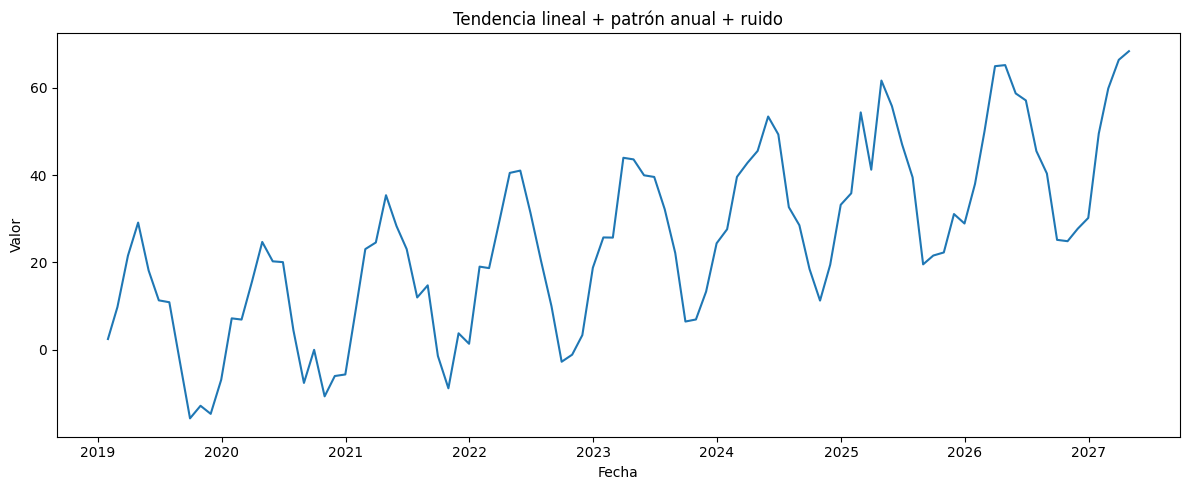

100%|██████████| 100/100 [00:04<00:00, 21.25it/s, epoch=50/50, avg_epoch_loss=0.908]


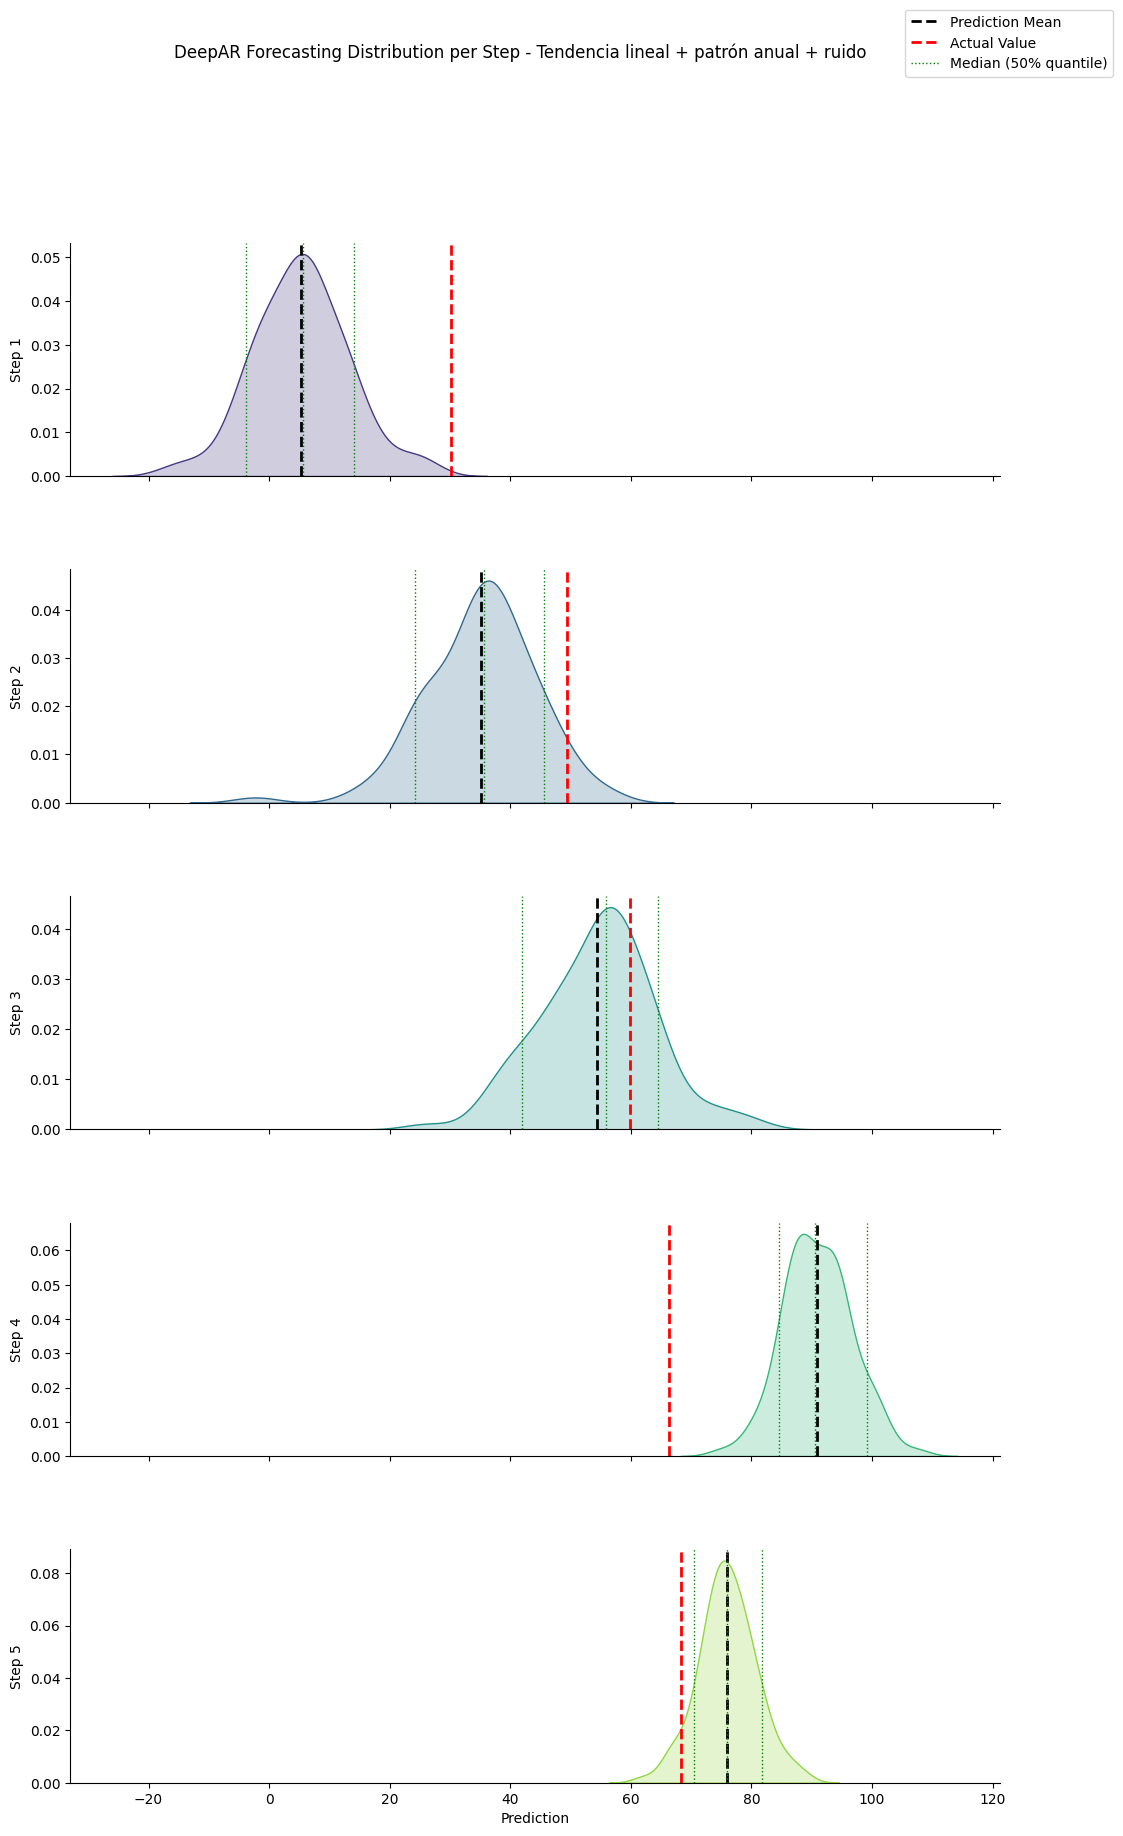

Resumen de predicciones para Tendencia lineal + patrón anual + ruido:

Paso 1:
  Valor real: 30.18
  Predicción media: 5.31
  Predicción mediana: 5.59
  Intervalo de predicción (80%): [-3.83, 13.94]

Paso 2:
  Valor real: 49.48
  Predicción media: 35.15
  Predicción mediana: 35.82
  Intervalo de predicción (80%): [24.12, 45.59]

Paso 3:
  Valor real: 59.81
  Predicción media: 54.44
  Predicción mediana: 55.92
  Intervalo de predicción (80%): [41.95, 64.47]

Paso 4:
  Valor real: 66.35
  Predicción media: 90.96
  Predicción mediana: 90.77
  Intervalo de predicción (80%): [84.57, 99.13]

Paso 5:
  Valor real: 68.33
  Predicción media: 75.99
  Predicción mediana: 76.10
  Intervalo de predicción (80%): [70.55, 81.74]


In [7]:

mx.random.seed(42)
np.random.seed(42)


# Example usage:
start_date = pd.Timestamp("2019-01-01")
num_samples = 100

# Generate the time series
time_series1 = np.arange(num_samples) * 0.5 + \
               np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20 + \
               np.random.normal(loc=0, scale=5, size=num_samples)

time_series = [time_series1]
titles = ['Tendencia lineal + patrón anual + ruido']

# Create and use the forecaster
forecaster = DeepARForecasting(start_date="2019-01-01", freq="ME", prediction_length=5)

for series, title in zip(time_series, titles):
    forecaster.add_time_series(series, title)

forecaster.plot_input_series()

forecaster.run_forecasting_process(series_index=0)

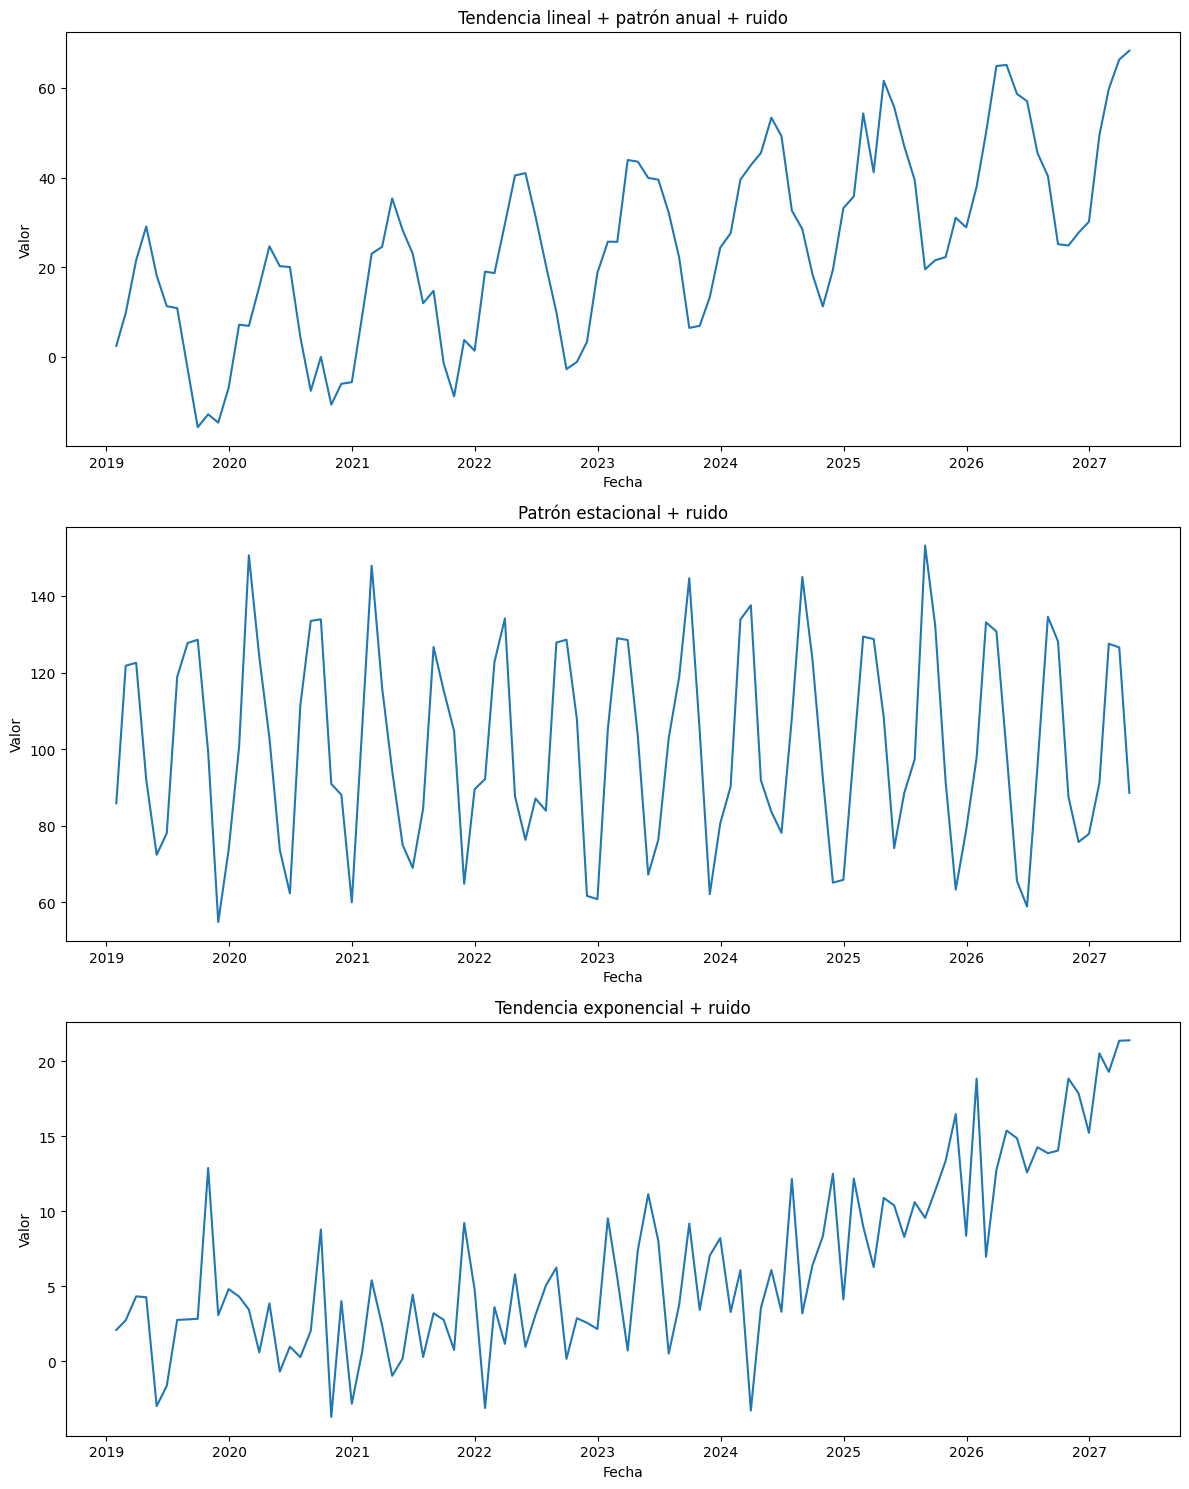

100%|██████████| 100/100 [00:04<00:00, 21.94it/s, epoch=50/50, avg_epoch_loss=1.94]


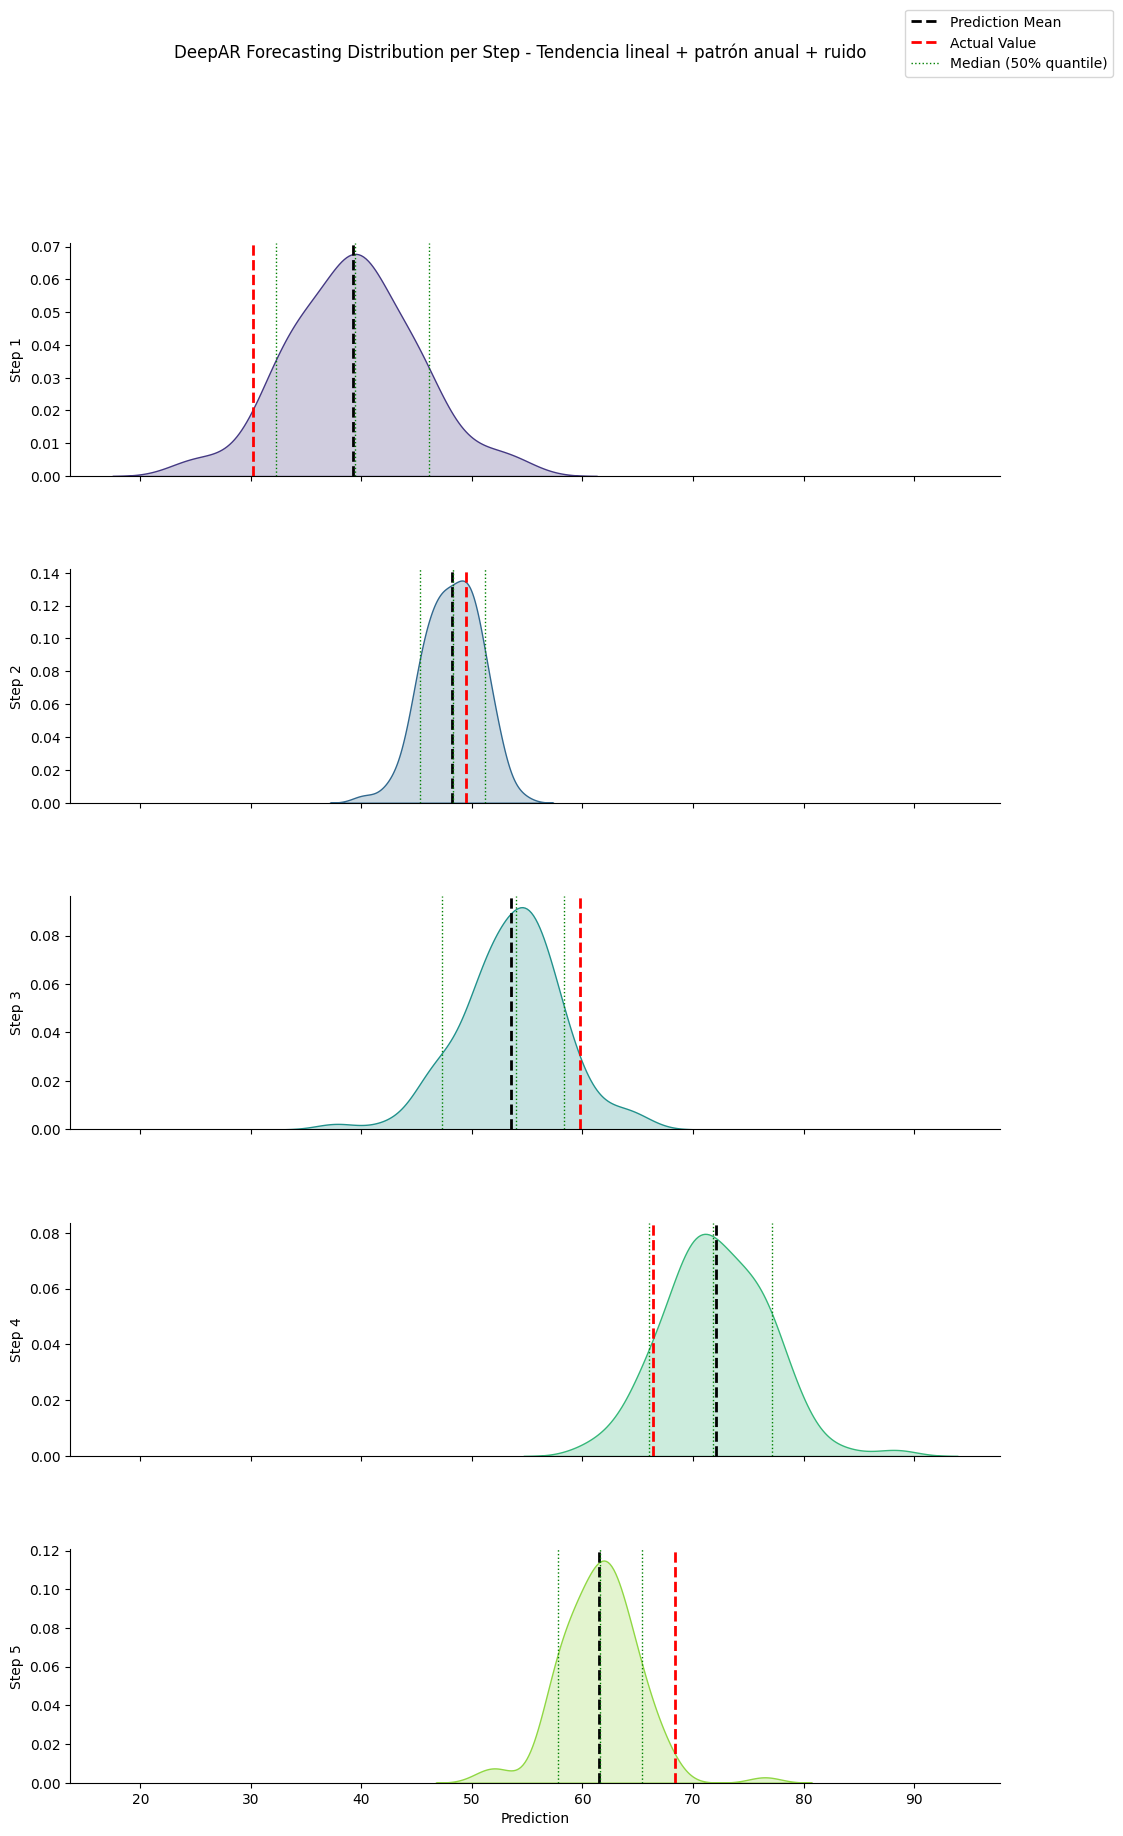

Resumen de predicciones para Tendencia lineal + patrón anual + ruido:

Paso 1:
  Valor real: 30.18
  Predicción media: 39.24
  Predicción mediana: 39.46
  Intervalo de predicción (80%): [32.29, 46.09]

Paso 2:
  Valor real: 49.48
  Predicción media: 48.20
  Predicción mediana: 48.38
  Intervalo de predicción (80%): [45.36, 51.19]

Paso 3:
  Valor real: 59.81
  Predicción media: 53.57
  Predicción mediana: 54.04
  Intervalo de predicción (80%): [47.33, 58.35]

Paso 4:
  Valor real: 66.35
  Predicción media: 72.11
  Predicción mediana: 71.86
  Intervalo de predicción (80%): [66.02, 77.14]

Paso 5:
  Valor real: 68.33
  Predicción media: 61.52
  Predicción mediana: 61.62
  Intervalo de predicción (80%): [57.77, 65.40]


In [6]:

mx.random.seed(42)
np.random.seed(42)


# Example usage:
start_date = pd.Timestamp("2019-01-01")
num_samples = 100

# Generate the time series
time_series1 = np.arange(num_samples) * 0.5 + \
               np.sin(np.arange(num_samples) * 2 * np.pi / 12) * 20 + \
               np.random.normal(loc=0, scale=5, size=num_samples)

time_series2 = np.sin(np.arange(num_samples) * 2 * np.pi / 6) * 30 + \
               np.random.normal(loc=100, scale=10, size=num_samples)

time_series3 = np.exp(np.arange(num_samples) * 0.03) + \
               np.random.normal(loc=0, scale=3, size=num_samples)

time_series = [time_series1, time_series2, time_series3]
titles = ['Tendencia lineal + patrón anual + ruido',
          'Patrón estacional + ruido',
          'Tendencia exponencial + ruido']

# Create and use the forecaster
forecaster = DeepARForecasting(start_date="2019-01-01", freq="ME", prediction_length=5)

for series, title in zip(time_series, titles):
    forecaster.add_time_series(series, title)

forecaster.plot_input_series()

forecaster.run_forecasting_process(series_index=0)